In [2]:
from typing import TypedDict, Dict, List
from langgraph.graph import StateGraph, END
import random

In [3]:
class AgentState(TypedDict):
    name: str
    random_number: int
    guess_count: int
    user_guess: int
    message: str

In [4]:
def greeting_node(state: AgentState) -> AgentState:
    # Only set random_number if it's not already set (first run)
    if 'random_number' not in state or state.get('random_number', 0) == 0:
        state['random_number'] = random.randint(1, 20)
        state['guess_count'] = 0
        state['user_guess'] = 0
        state["message"] = f"Hello, {state['name']}! Let's play a number guessing game. I have selected a random number between 1 and 20. let's see how many attempts you need to guess it!"
    return state

def check_guess_node(state: AgentState) -> AgentState:
    # Skip if no real guess yet
    if state['user_guess'] == 0:
        return state
    
    state['guess_count'] += 1
    if state['user_guess'] < state['random_number']:
        state['message'] = f"Too low! Try again. (Attempt {state['guess_count']})"
    elif state['user_guess'] > state['random_number']:
        state['message'] = f"Too high! Try again. (Attempt {state['guess_count']})"
    else:
        state['message'] = f"🎉 Correct! You've guessed the number {state['random_number']} in {state['guess_count']} attempts."
    return state

def should_continue(state: AgentState) -> str:
    # If no guess yet, finish (to avoid infinite loop on first run)
    if state['user_guess'] == 0:
        return "finish"
    # If guessed correctly, finish
    if state['user_guess'] == state['random_number']:
        return "finish"
    # Otherwise, try again
    return "try_again"

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("greeting", greeting_node)
graph.add_node("check_guess", check_guess_node)

# Conditional edge from greeting - only go to check_guess if there's a guess
graph.add_conditional_edges(
    "greeting",
    lambda state: "check" if state.get('user_guess', 0) > 0 else "done",
    {
        "check": "check_guess",
        "done": END
    }
)

graph.add_conditional_edges(
    "check_guess", 
    should_continue,
    {
        "try_again": "check_guess",  # Changed: don't loop, just end
        "finish": END
    }
)

graph.set_entry_point("greeting")
app = graph.compile()

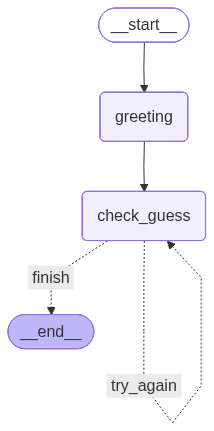

In [6]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
# Start the game - get initial greeting
game = app.invoke({"name": "Player1"})
print(game['message'])
print(f"\n[Debug: The secret number is {game['random_number']}]")  # For testing

# Interactive game loop
while game['user_guess'] != game['random_number']:
    try:
        guess = int(input("\nEnter your guess (1-20): "))
        
        if 1 <= guess <= 20:
            # Update state with user's guess
            game['user_guess'] = guess
            # Run the graph again with the updated state
            game = app.invoke(game)
            print(game['message'])
        else:
            print("❌ Please enter a number between 1 and 20!")
    except ValueError:
        print("❌ Please enter a valid number!")
    except KeyboardInterrupt:
        print("\n\nGame interrupted. Thanks for playing!")
        break

print("\n✅ Game completed!")

Hello, Player1! Let's play a number guessing game. I have selected a random number between 1 and 20. let's see how many attempts you need to guess it!

[Debug: The secret number is 13]


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT